In [1]:
import numpy as np
import random
import cv2
import matplotlib.pyplot as plt
from keras.layers import Input , Dense , Conv2D , Conv1D , Dropout , Flatten , concatenate , ZeroPadding1D,ZeroPadding2D , BatchNormalization,MaxPool2D,AveragePooling2D
from keras import Model
from keras.optimizers import RMSprop , Adam
import tensorflow as tf
import keras.backend as K

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#img = cv2.imread("/home/mayur/Downloads/hubble_friday_05132016.jpg" , cv2.IMREAD_GRAYSCALE)

In [3]:
#plt.imshow(img)

In [73]:
person_to_train = 30
each_image_person = 10

In [4]:
def create_pairs(x , total_subjects , each_images , dir):
    pairs = []
    
    for i in range(1 , total_subjects+1):
        for j in range(1 , each_images + 71):
            anchor_no = random.randint(1 , 10)
            positive_no = random.randint(1 , 10)
            negative_dir = random.randint(1 , 40)
            negative_no = random.randint(1 , 10)
            
            anchor_img = cv2.imread(dir + "/s" + str(i) + "/" + str(anchor_no) + ".pgm", cv2.IMREAD_GRAYSCALE)
            positive_img = cv2.imread(dir + "/s" + str(i) + "/" + str(positive_no) + ".pgm", cv2.IMREAD_GRAYSCALE)
            negative_img = img = cv2.imread(dir + "/s" + str(negative_dir) + "/" + str(negative_no) + ".pgm", cv2.IMREAD_GRAYSCALE)
            #print(positive_img.shape)
            pairs.append([[anchor_img / 255] , [positive_img / 255] , [negative_img / 255]])
            #print("for " , i , pairs)
            #print("neg is ",negative_dir)
    return np.squeeze(np.array(pairs))

In [74]:
pairs = create_pairs(1 , person_to_train , each_image_person , "att_faces")

In [40]:
pairs.shape

(2400, 3, 112, 92)

In [41]:
img = np.expand_dims(pairs[0 , 0] , axis = 2)

In [42]:
img.shape

(112, 92, 1)

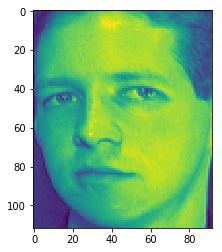

In [43]:
plt.imshow(np.squeeze(img))

In [44]:
pairs_expanded = []

In [45]:
for i in range(0 , pairs.shape[0]):
    anch = np.expand_dims(pairs[i,0] , axis = 2)
    pos = np.expand_dims(pairs[i,1] , axis = 2)
    neg = np.expand_dims(pairs[i,2] , axis = 2)
    pairs_expanded.append((anch , pos , neg))

In [46]:
import pickle
with open("pairs_expanded.pkl" , "wb") as file:
    pickle.dump(pairs_expanded , file)

In [47]:
np.save("pairs_expanded.npy" , pairs_expanded)

In [14]:
#pairs_expanded contain ((anch,pos,neg)) in pe[0]

In [48]:
pairs_expanded = np.array(pairs_expanded)

In [49]:
pairs_expanded.shape

(2400, 3, 112, 92, 1)

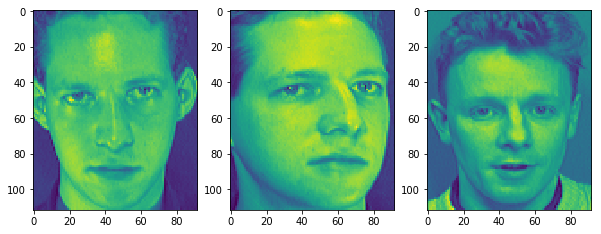

In [50]:
fig , ax = plt.subplots(1,3,figsize = (10,10))

ax[0].imshow(np.squeeze(pairs_expanded[11][0]))
ax[1].imshow(np.squeeze(pairs_expanded[11][1]))
ax[2].imshow(np.squeeze(pairs_expanded[11][2]))

In [18]:
def triplet_loss(y_true, y_pred, alpha = 0.2):
    
    #anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    anchor, positive, negative = y_pred[:,0:128], y_pred[:,128:256], y_pred[:,256:384]
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor , positive)), axis=-1)
    
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor , negative) ), axis=-1)
    
    basic_loss = tf.add(tf.subtract(pos_dist , neg_dist) , alpha)
    
    loss = tf.reduce_sum(tf.maximum(basic_loss , 0.0))
    
    return loss

In [51]:
input_shape = (112 , 92 , 1)

In [20]:
"""input = Input(shape = input_shape)
x = Flatten()(input)
x = Dense(1024 , activation = "relu")(x)
#x = Dropout(0.1)(x)
x = Dense(512 , activation = "relu")(x)
x = Dense(512 , activation = "relu")(x)
#x = Dropout(0.1)(x)
x = Dense(256 , activation = "relu")(x)
x = Dense(256 , activation = "relu")(x)
#x = Dropout(0.1)(x)
x = Dense(128 , activation = "relu")(x)
x = Dense(128 , activation = "relu")(x)"""

'input = Input(shape = input_shape)\nx = Flatten()(input)\nx = Dense(1024 , activation = "relu")(x)\n#x = Dropout(0.1)(x)\nx = Dense(512 , activation = "relu")(x)\nx = Dense(512 , activation = "relu")(x)\n#x = Dropout(0.1)(x)\nx = Dense(256 , activation = "relu")(x)\nx = Dense(256 , activation = "relu")(x)\n#x = Dropout(0.1)(x)\nx = Dense(128 , activation = "relu")(x)\nx = Dense(128 , activation = "relu")(x)'

In [52]:
model_input = Input(shape = input_shape)
#x = ZeroPadding2D((1,1))(input)
x = Conv2D(6 , kernel_size=(3,3) , padding = "same" , activation = "relu")(model_input)
#x = ZeroPadding2D((1,1))(x)
x = AveragePooling2D(pool_size=(2,2))(x)
x = Conv2D(12 , kernel_size = (3,3) , padding = "same" , activation = "relu")(x)
#x = ZeroPadding2D((2,2))(x)
x = Conv2D(24 , kernel_size = (3,3) , padding = "same" , activation = "relu")(x)
#x = ZeroPadding2D((2,2))(x)
x = AveragePooling2D(pool_size = (2,2))(x)
x = Conv2D(48 , kernel_size = (3,3) , padding = "same" , activation = "relu")(x)
#x = ZeroPadding2D((1,1))(x)
x = Conv2D(60 , kernel_size = (3,3) , padding = "same" , activation = "relu")(x)
x = Flatten()(x)
model_output = Dense(128 , activation = "relu")(x)

In [22]:
"""x = Conv2D(256 , kernel_size=(6,6) , padding = "valid" , activation="relu")(input)
x = ZeroPadding2D(padding = (2,2))(x)
x = Conv2D(128 , kernel_size=(6,6) , padding = "valid" , activation="relu")(x)"""

'x = Conv2D(256 , kernel_size=(6,6) , padding = "valid" , activation="relu")(input)\nx = ZeroPadding2D(padding = (2,2))(x)\nx = Conv2D(128 , kernel_size=(6,6) , padding = "valid" , activation="relu")(x)'

In [53]:
print(model_input.shape)
print(model_output.shape)

(?, 112, 92, 1)
(?, 128)


In [54]:
base_network = Model(model_input , model_output)

In [55]:
base_network.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 112, 92, 1)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 112, 92, 6)        60        
_________________________________________________________________
average_pooling2d_3 (Average (None, 56, 46, 6)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 56, 46, 12)        660       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 56, 46, 24)        2616      
_________________________________________________________________
average_pooling2d_4 (Average (None, 28, 23, 24)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 28, 23, 48)        10416     
__________

In [56]:
input_1 = Input(shape = input_shape)
input_2 = Input(shape = input_shape)
input_3 = Input(shape = input_shape)

In [57]:
output_1 = base_network(input_1)
output_2 = base_network(input_2)
output_3 = base_network(input_3)

In [58]:
output = concatenate([output_1 , output_2 , output_3] , axis=1)

In [29]:
#output.shape

In [59]:
finalModel = Model(inputs=[input_1 , input_2 , input_3] , outputs = output)

In [60]:
finalModel.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 112, 92, 1)   0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            (None, 112, 92, 1)   0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 112, 92, 1)   0                                            
__________________________________________________________________________________________________
model_3 (Model)                 (None, 128)          4985780     input_6[0][0]                    
                                                                 input_7[0][0]                    
          

In [61]:
finalModel.compile(loss = triplet_loss , optimizer=Adam()  , metrics = ["accuracy"])

In [62]:
y_dummie = np.zeros(pairs.shape[0])
y_dummie.shape

(2400,)

In [63]:
pairs_expanded.shape

(2400, 3, 112, 92, 1)

In [64]:
pairs.shape

(2400, 3, 112, 92)

In [66]:
finalModel.fit([pairs_expanded[:,0] , pairs_expanded[:,1] , pairs_expanded[:,2]] , y_dummie , batch_size = 16 , epochs = 3)

Epoch 1/3
2400/2400 [==============================] - 144s 60ms/step - loss: 0.2057 - acc: 0.0000e+00
Epoch 2/3
2400/2400 [==============================] - 133s 56ms/step - loss: 0.1055 - acc: 0.0000e+00
Epoch 3/3
2400/2400 [==============================] - 130s 54ms/step - loss: 0.1078 - acc: 0.0000e+00


In [67]:
K.set_value(finalModel.optimizer.lr, 1e-4)
finalModel.fit([pairs_expanded[:,0] , pairs_expanded[:,1] , pairs_expanded[:,2]] , y_dummie , batch_size = 8 , epochs = 1)

Epoch 1/1
2400/2400 [==============================] - 172s 72ms/step - loss: 0.0365 - acc: 0.0000e+00


In [77]:
def get_embed_dict(dir , total_person , model):
    embed = {}
    for i in range(1 , total_person + 1):
        
        path = "att_faces/s1/1.pgm"
        #one_img = cv2.imread(dir + "/s" + str(i) + "/" + str(1) + ".pgm", cv2.IMREAD_GRAYSCALE) / 255
        one_img = cv2.imread("att_faces" + "/s" + str(i) + "/" + str(1) + ".pgm", cv2.IMREAD_GRAYSCALE) / 255
        img = np.expand_dims(one_img , axis = 2)
        img = np.expand_dims(img , axis = 0)
        pred = model.predict(img)
        name = "s" + str(i)
        
        embed.update({name : pred})
    return embed

In [78]:
embed = get_embed_dict("att_faces" , person_to_train , base_network)

In [87]:
len(embed)

30

In [ ]:
#embed.get("s8")

In [80]:
pickle.dump(embed , file=open("embeddings.pkl" , mode = "wb"))

In [81]:
index = 93
anchor = pairs_expanded[index,0]
pos = pairs_expanded[index,1]
neg = pairs_expanded[index,2]

In [82]:
anchor.shape

(112, 92, 1)

In [83]:
base_network.predict(np.expand_dims(anchor , axis = 0)).shape

(1, 128)

In [84]:
def findPerson(preds , number):
    true_emb = base_network.predict(np.expand_dims(pairs_expanded[number , 0] , axis = 0))
    dist = np.sum(np.square(np.subtract(true_emb , preds)))
    
    if dist < 0.5:
        print("Same Person")
    else:
        print("Not Same")
    
    print(dist)

In [85]:
index = 624
anchor = pairs_expanded[index,0]
pos = pairs_expanded[index,1]
neg = pairs_expanded[index,2]

preds = np.squeeze(base_network.predict(np.expand_dims(pos , axis = 0)))

findPerson(preds , index)

Same Person
0.3206123


In [88]:
base_network.save(filepath="Base_siamese_network_v3.h5")
base_network.save_weights(filepath="Base_siamese_network_v3_weights.h5")

In [ ]:
from keras.models import load_model

model = load_model("Base_siamese_network_v3.h5")

In [ ]:
one_img = cv2.imread("att_faces" + "/s" + str(1) + "/" + str(1) + ".pgm", cv2.IMREAD_GRAYSCALE) / 255
img = np.expand_dims(one_img , axis = 2)
img = np.expand_dims(img , axis = 0)
pred1 = model.predict(img)
pred2 = base_network.predict(img)

In [ ]:
embed.get("s1") - pred1